In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [4]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
data_files = f'{hadoopUrl}/precipitation/data/agg/from/1955/*.parquet'

# Obtain dataset
df = spark.read.parquet(data_files).select("date","precipitation").toPandas()

In [5]:
# Set the date column as the index and ensure it's a DatetimeIndex
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,precipitation
date,
1956-01-01,3.596281
1956-01-02,8.505372
1956-01-03,0.068595
1956-01-04,0.023554
1956-01-05,0.042562


## Plot series different time scales. Remove outliers


In [6]:
def seasonality_plots(grouped, freq="1D", start = '2015-01-01', end = '2023-01-01', remove_outliers = True):
    df_s = grouped[(grouped.index >= start) & (grouped.index <= end)]

    if(remove_outliers):
        # Calculate the IQR
        Q1 = df_s['precipitation'].quantile(0.25)
        Q3 = df_s['precipitation'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        # Filter out the outliers
        df_s = df_s[(df_s['precipitation'] >= lower_bound) & (df_s['precipitation'] <= upper_bound)]

    # Prepare data
    df_s['year'] = [d.year for d in df_s.index]
    df_s['month'] = [d.strftime('%b') for d in df_s.index]
    years = df_s['year'].unique()
    
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='precipitation', data=df_s, ax=axes[0])
    sns.boxplot(x='month', y='precipitation', data=df_s.loc[~df_s.year.isin([1900, 2023]), :])

    # Set Title
    axes[0].set_title(f'{freq} Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title(f'{freq} Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()
    
    
    x = df_s.index
    y1 = df_s['precipitation'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120, )
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-15, 15)
    plt.title(f'Precipitation {freq} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(df_s.index), xmax=np.max(df_s.index), linewidth=.5)
    plt.show()

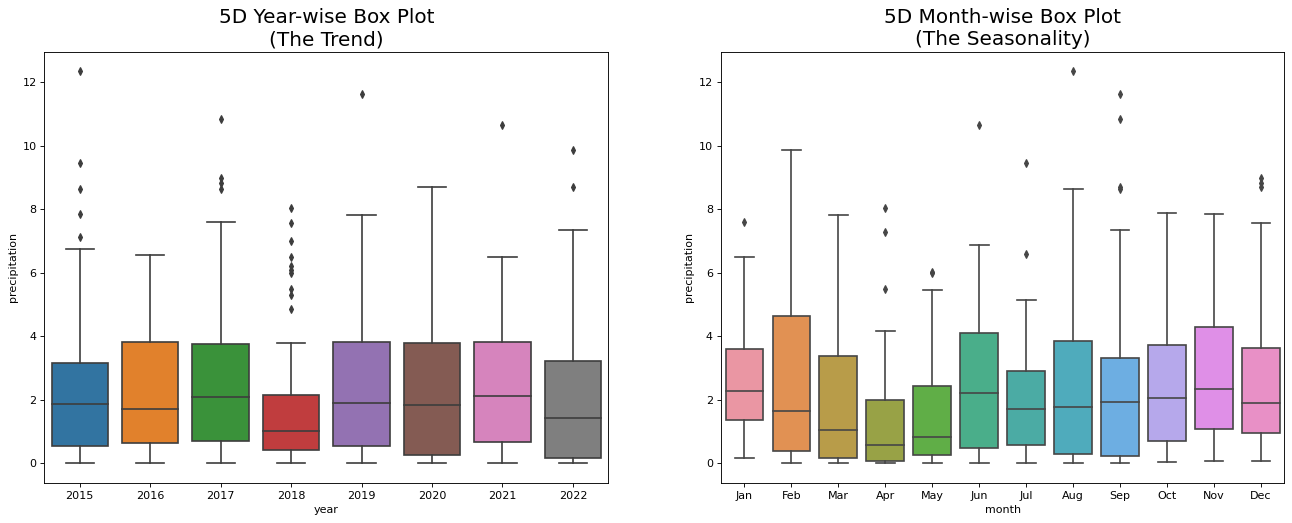

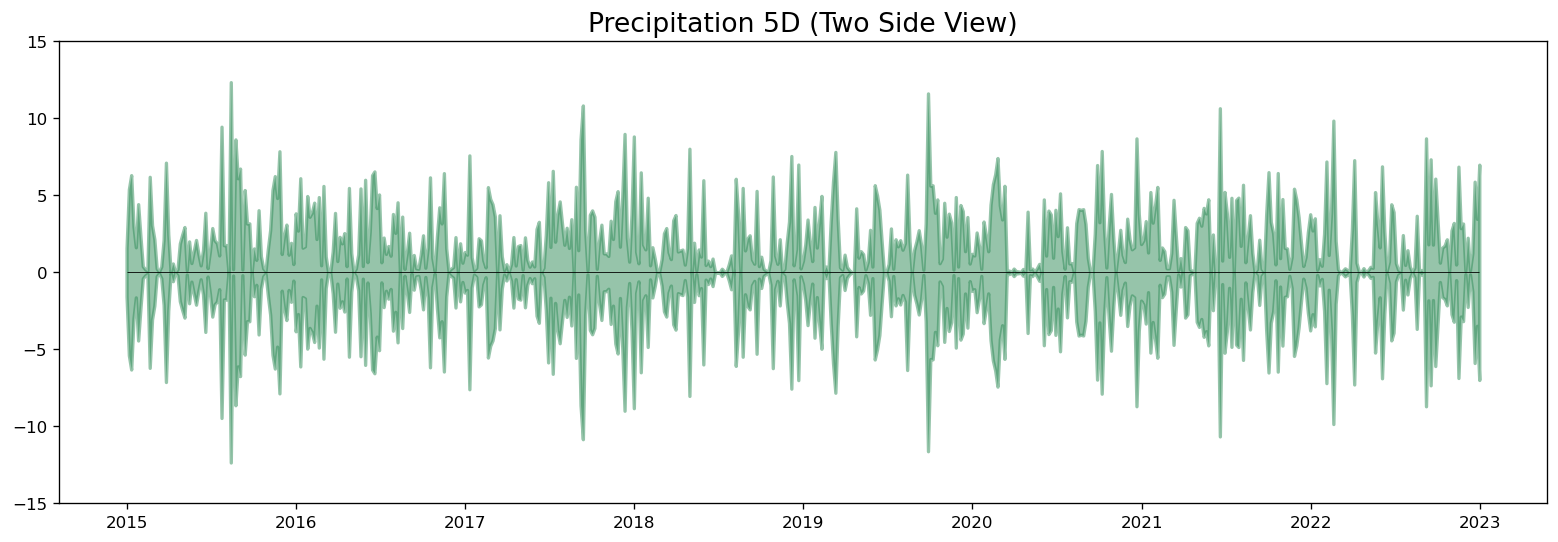

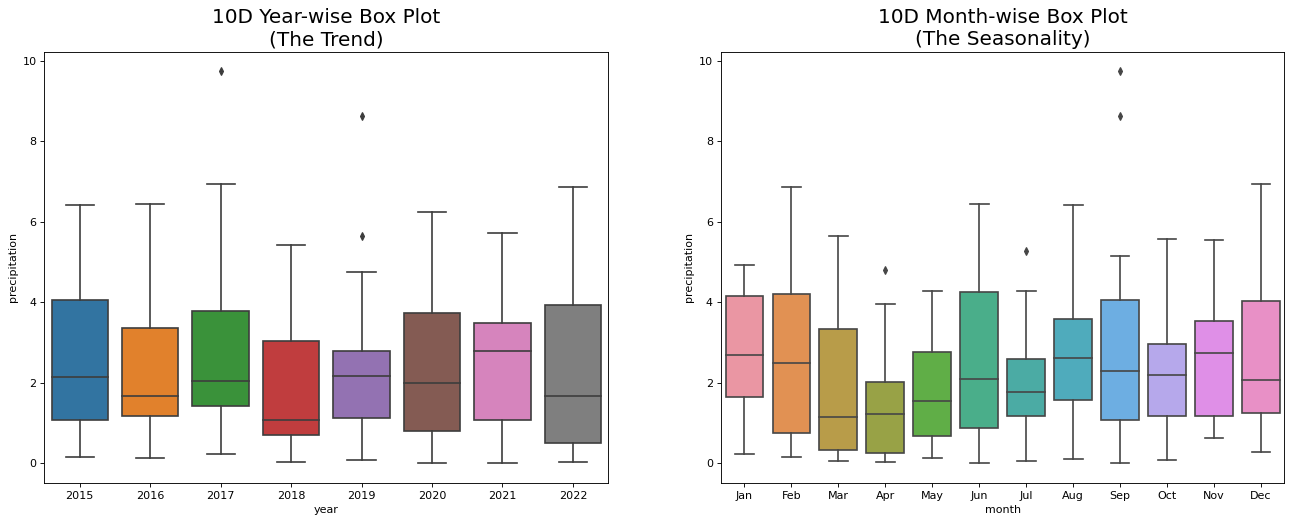

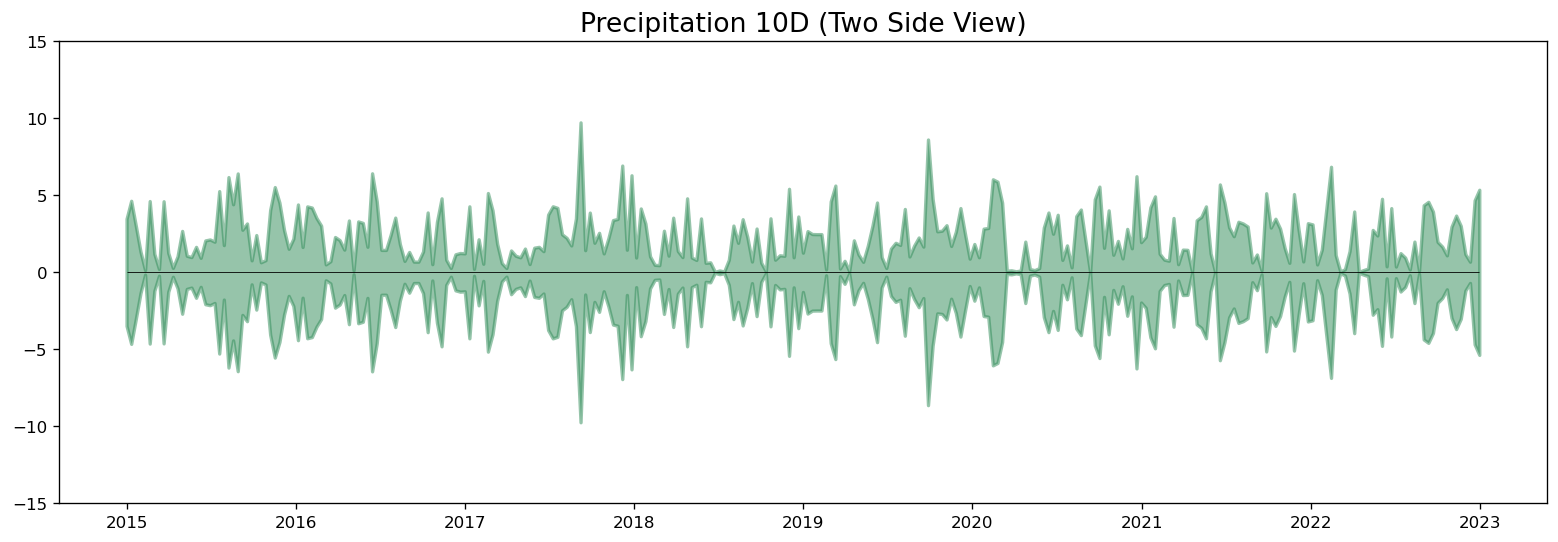

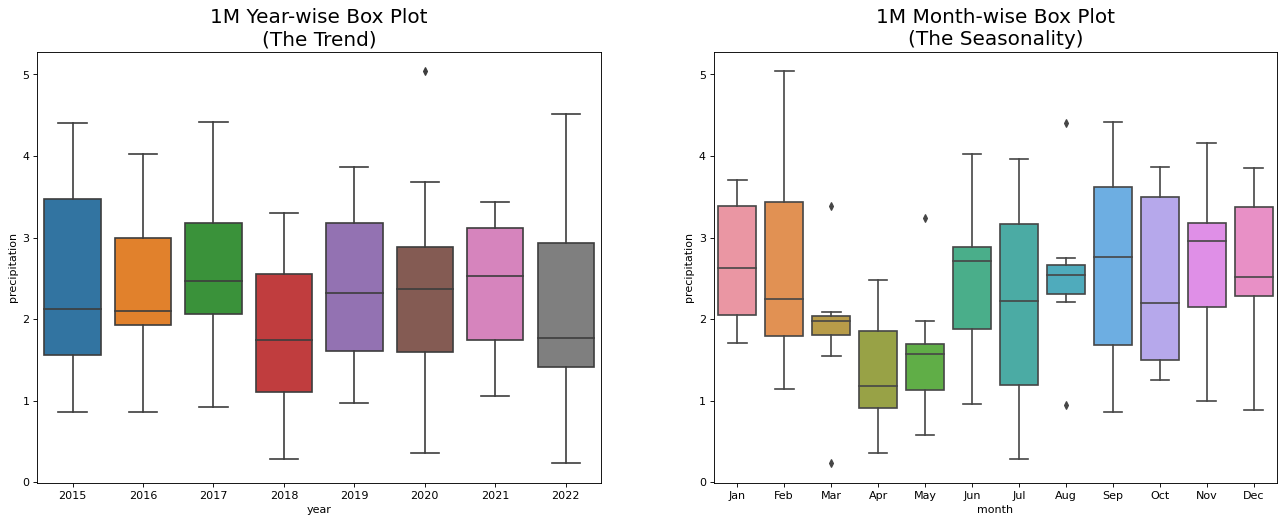

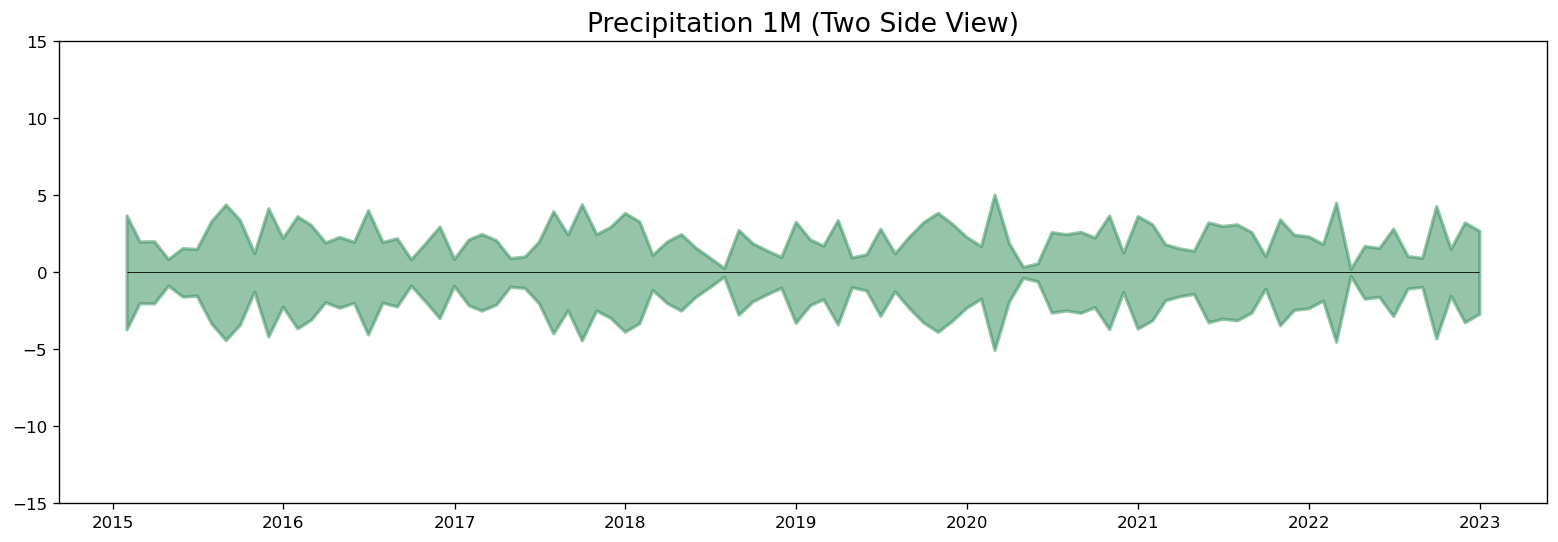

In [7]:
grouped = df.groupby(pd.Grouper(freq='5d')).mean()
seasonality_plots(grouped,freq="5D",remove_outliers=False)

grouped = df.groupby(pd.Grouper(freq='10d')).mean()
seasonality_plots(grouped,freq="10D",remove_outliers=False)

grouped = df.groupby(pd.Grouper(freq='1M')).mean()
seasonality_plots(grouped,freq="1M",remove_outliers=False)

# Seasonality Decomposition

In [8]:
#%pip install statsmodels

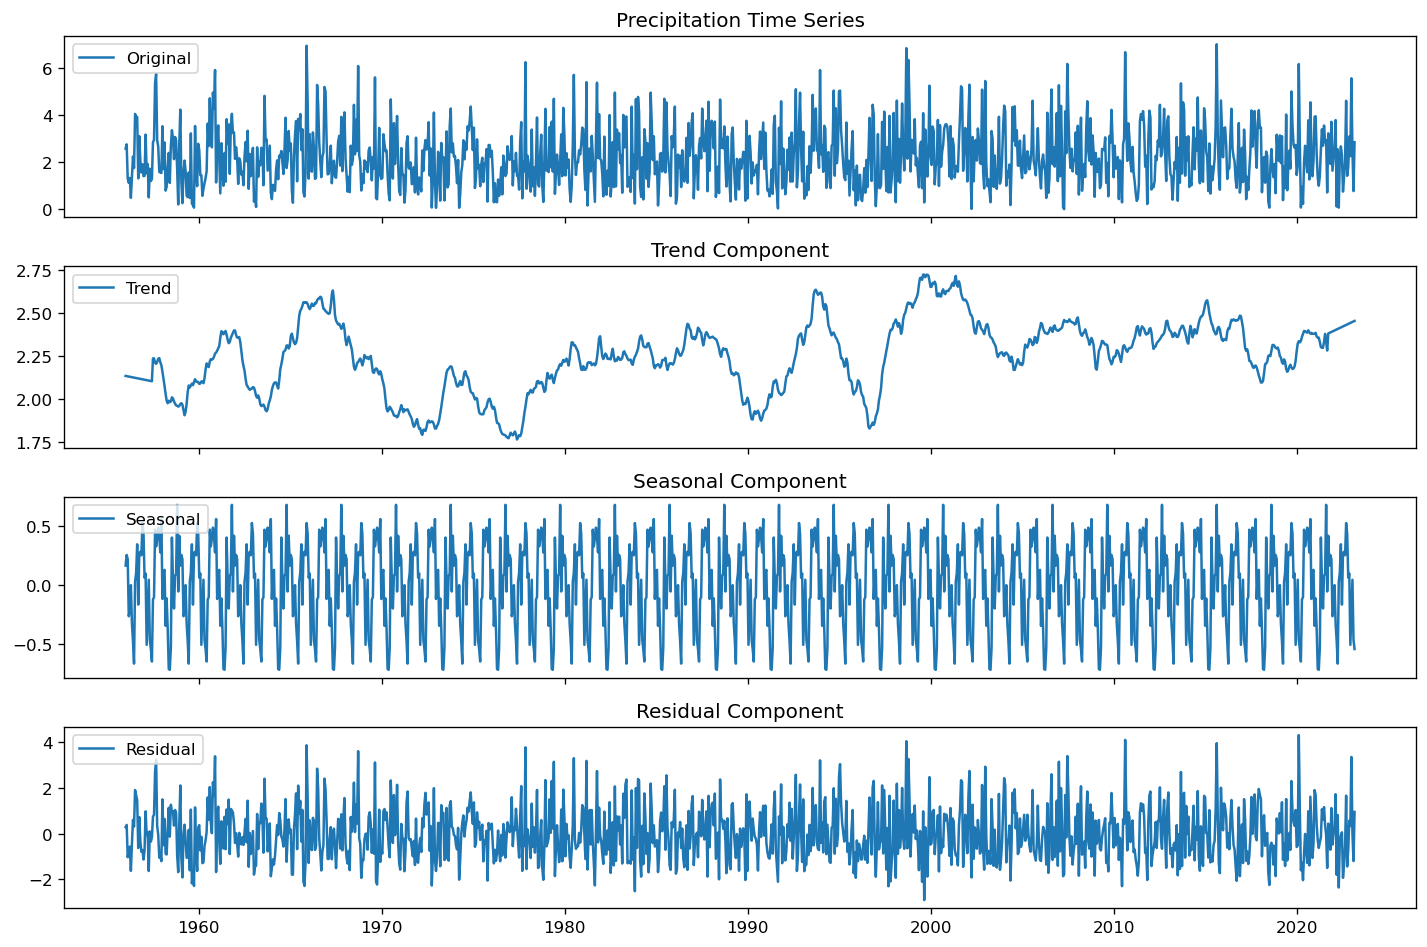

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline

df_seasson = df.resample('21d').mean()
df_seasson = df_seasson.sort_index()
decomposition = seasonal_decompose(df_seasson['precipitation'], model='additive', extrapolate_trend='freq')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Plot the original time series
ax1.plot(df_seasson['precipitation'], label='Original')
ax1.legend(loc='upper left')
ax1.set_title('Precipitation Time Series')

# Plot the trend component
ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax2.set_title('Trend Component')

# Plot the seasonal component
ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_title('Seasonal Component')

# Plot the residual component
ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()


# Stationary Test

In [10]:
#%pip install arch

In [100]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def test_stationarity(time_series):
    # Perform ADF test
    adf_result = adfuller(time_series, autolag='AIC')
    print("ADF Test:")
    print("=========")
    print(f"Test statistic: {adf_result[0]}")
    print(f"null_hypothesis: the time series is non-stationary")
    p_value = adf_result[1]
    print(f"P-value: {p_value}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"{key}: {value}")
    
    result = "STATIONARY" if p_value < 0.05 else "NON-STATIONARY"
    print(result)
    

    print("\nKPSS Test:")
    print("============")
    kpss_result = kpss(time_series, regression='ct')  # 'ct' for constant and trend
    print(f"null_hypothesis: the time series is trend stationary")
    print(f"Test statistic: {kpss_result[0]}")
    print(f"P-value: {kpss_result[1]}")
    p_value = kpss_result[1]
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"{key}: {value}")
        
    result = "NON-STATIONARY" if p_value < 0.05 else "STATIONARY"
    print(result)


In [101]:
test_stationarity(df_seasson['precipitation'])


ADF Test:
Test statistic: -6.504379241185764
null_hypothesis: the time series is non-stationary
P-value: 1.140809092372856e-08
Critical values:
1%: -3.436044130146462
5%: -2.864054342974637
10%: -2.568108697208109
STATIONARY

KPSS Test:
null_hypothesis: the time series is trend stationary
Test statistic: 0.052523353677860644
P-value: 0.1
Critical values:
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216
STATIONARY


/anaconda/envs/py38_default/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# LSTM

In [163]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [178]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.resample('7d').mean())
look_back = 4


In [179]:
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


In [180]:
train_data, test_data = train_test_split(scaled_data, test_size=0.2)

In [181]:
X, y = create_sequences(train_data, look_back)
#X = X.reshape(X.shape[0], X.shape[1], 1)

In [185]:
units = 10
dropout_rate = 0.2

model = Sequential()
model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(dropout_rate))

#model.add(LSTM(units = units, return_sequences = True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = units, return_sequences = True))
#model.add(Dropout(0.2))

model.add(LSTM(units))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [186]:
train_X.shape, train_y.shape

((3903, 30, 1), (3903,))

In [187]:
model.fit(train_X, train_y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


ValueError: in user code:

    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/anaconda/envs/py38_default/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_24" is incompatible with the layer: expected shape=(None, 4, 1), found shape=(None, 30, 1)


In [ ]:
predictions = model.predict(final_x_test_data)